## Profile likelihood method for detemining uncertaininty contributions in DM direct detection searches from uncertanity in local DM VDF of MW

In [1]:
import numpy as np 
import sys, pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

sys.path.append('../../')
from project.recoil import Nuclear as Nr, p50, norm, get_vdf_ert
from project.nuclear_pll import MLE
from project.nuclear_pll import StatisticalUncertanity as Stat 
from project.nuclear_pll import MassModelUncertanity as MassModel
from project.nuclear_pll import SampleUncertanity as Samp
from project.tools.plot_assist import multiline, truncate_colormap

import matplotlib
matplotlib.rcParams['font.family'] = 'sans'
matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'
matplotlib.rcParams['figure.figsize'] = (6,5)
matplotlib.rcParams['font.size'] = 12


In [2]:
MWlike = pickle.load(open('../../Output/MWlike_dict.pkl','rb'))
mwld = MWlike['vdf_RCfit']
mwd = mwld['MW']
mwgals = MWlike['mwgals']

In [3]:
nr_init = Nr('Xe', vE=mwd['vE'], vdfE=mwd['vdfE_50'], vesc=p50(mwd['vescs']), vcirc=p50(mwd['vcircs']), rhosun=p50(mwd['rhosuns']), Ethr=0.1, Eroi=5.0, ω=10.0)
mock = nr_init.mocksample(4., 1e-45, 0.001, seed=5222)

In [18]:
Mdm = np.logspace(0,2,30)
Sdm_1 = nr_init.σpMdmNsg(Mdm, ω=1, Ethr=1)
Sdm_10 = nr_init.σpMdmNsg(Mdm, ω=10)

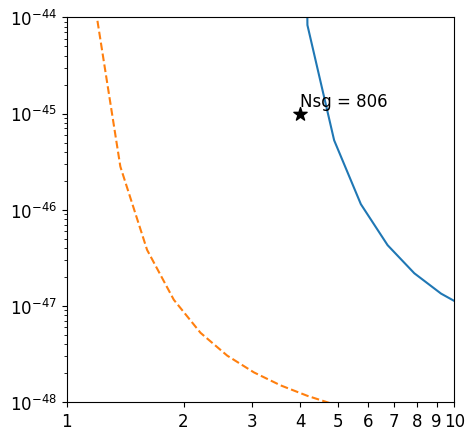

In [22]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(Mdm, Sdm_1)
ax.plot(Mdm, Sdm_10, ls='--')

ax.scatter(4, 1e-45, c='k', marker='*', s=100)
ax.text(4, 1.2e-45, 'Nsg = %i'%nr_init.totNsg(4, 1e-45))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,10)
ax.set_ylim(1e-48,1e-44)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]);

In [5]:
%%time
rate = nr_init.diffSg(10., 1e-45)

CPU times: user 36.6 ms, sys: 569 µs, total: 37.2 ms
Wall time: 36 ms


In [4]:
stat = Stat(mock, nr_init, Mdm=np.linspace(3,5,50))
statlim = stat.get_limits(stat.Mdm)

In [5]:
mm = MassModel(mock, nr_init, Mdm=np.around(np.linspace(3,5,50),2), chainlen=100)
mmlim = mm.get_limits(mm.Mdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
samp = Samp(mock, nr_init, Mdm=np.linspace(2,5,50), run_parallel=True, percentiles=np.arange(5,96,1))
samplim = samp.get_limits(samp.Mdm)
samplim_99 = samp.get_limits(samp.Mdm, tq_limit=9.21)

  0%|          | 0/91 [00:00<?, ?it/s]

In [7]:
pb = MassModel(mock, nr_init, Mdm=np.around(np.linspace(3,5,50),2), chainlen=100, gal='PB')
pblim = pb.get_limits(pb.Mdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
nrd = pickle.load(open('../../Output/Nuclear_dict.pkl','rb'))
nrd['limits']['statistical'] = statlim
nrd['limits']['massmodel'] = mmlim
nrd['limits']['massmodelPB'] = pblim
nrd['limits']['sample'] = samplim
nrd['min'] = {}
nrd['min']['statistical'] = [stat.mdm_min, stat.sdm_min]
nrd['min']['massmodel'] = [mm.mdm_min, mm.sdm_min]
nrd['min']['massmodelPB'] = [pb.mdm_min, pb.sdm_min]
nrd['min']['sample'] = [samp.mdm_min, samp.sdm_min]
# pickle.dump(nrd, open('../../Output/Nuclear_dict.pkl','wb'))

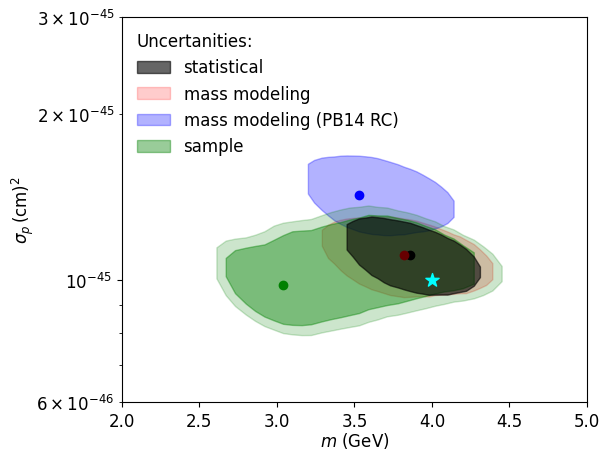

In [9]:
fig, ax = plt.subplots()
ax.fill_between(*statlim, color='k', alpha=0.6, label='statistical', zorder=2)
ax.fill_between(*mmlim, color='r', alpha=0.2, label='mass modeling', zorder=1)
ax.fill_between(*pblim, color='b', alpha=0.3, label='mass modeling (PB14 RC)')
ax.fill_between(*samplim, color='g', alpha=0.4, label='sample')
ax.fill_between(*samplim_99, color='g', alpha=0.2)
for mle, clr in zip([stat, samp, mm, pb], ['k', 'g', 'r', 'b']):
    ax.scatter(mle.mdm_min, mle.sdm_min, c=clr, zorder=1)
ax.scatter(4., 1e-45, c='cyan', marker='*', s=100, zorder=2)
ax.legend(frameon=False, title='Uncertanities:', loc='upper left', alignment='left')
ax.set_ylim(6e-46, 3e-45)
ax.set_xlim(2,5)
ax.set_yscale('log')
ax.set_xlabel('$m$ (GeV)', size=12, labelpad=0)
ax.set_ylabel('$\sigma_p\, \mathrm{(cm)^2}$', size=12, labelpad=0)
plt.savefig('../../Output/figures/nuclear/uncertanities_PBRC.png',bbox_inches='tight', dpi=300)

In [25]:
# Compute the percentile VDFs for sample uncertainity analysis

#1. MW + MW like galaxies
Vdfs, Vescs, Vcircs = [], [], []
for gal in ['MW'] + mwgals:
    Vdfs.append(mwld[gal]['vdfs'])
    Vescs.append(mwld[gal]['vescs'])
    Vcircs.append(mwld[gal]['vcircs'])
Vdfs = np.vstack(Vdfs).T 
Vescs = np.concatenate(Vescs)
Vcircs = np.concatenate(Vcircs)

percentiles = np.around(np.arange(1., 99., 1),2)
Vdf_pers = {}
VdfE_pers = {}
for per in tqdm(percentiles):
    Vdf_pers[per] = np.percentile(Vdfs, per, axis=1)
    VdfE_pers[per] = get_vdf_ert(vE=mwd['vE'], v=mwd['v'], vdf=Vdf_pers[per], vesc=np.percentile(Vescs, per), vcirc=np.percentile(Vcircs, per))

  0%|          | 0/98 [00:00<?, ?it/s]

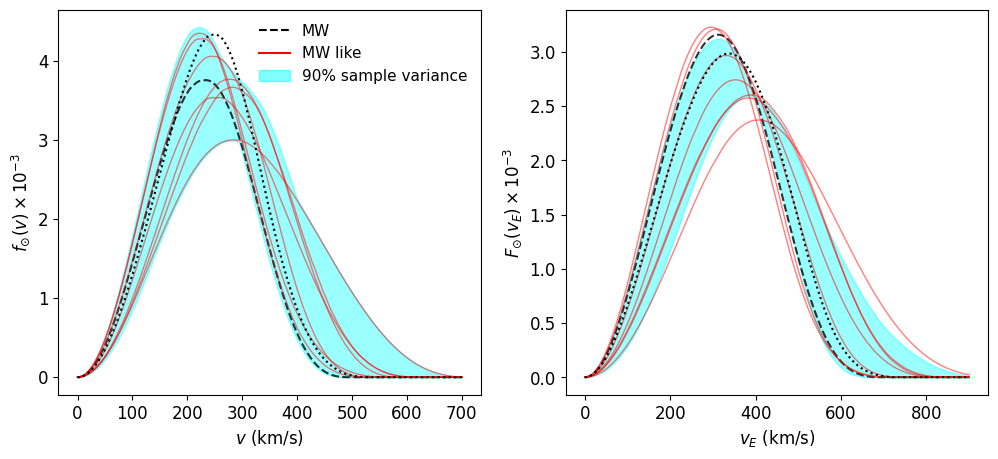

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axs

# for per in percentiles:
#     ax1.plot(mwd['v'], 1e3*Vdf_pers[per], c='grey', alpha=0.2, zorder=2)
#     ax2.plot(mwd['vE'], 1e3*VdfE_pers[per], c='grey', alpha=0.2, zorder=2)

for gal in ['MW']+mwgals:
    clr, lw, ls, alpha = ('k', 1.5, '--', 0.8) if gal == 'MW' else ('r', 1, '-', 0.5)
    ax1.plot(mwld[gal]['v'], 1e3*mwld[gal]['vdf_50'], c=clr, lw=lw, alpha=alpha, ls=ls, zorder=1)
    ax2.plot(mwld[gal]['vE'], 1e3*mwld[gal]['vdfE_50'], c=clr, lw=lw, alpha=alpha, ls=ls, zorder=1)
ax1.plot(mwld['PB']['v'], 1e3*mwld['PB']['vdf_50'], c='k', ls=':')
ax2.plot(mwld['PB']['vE'], 1e3*mwld['PB']['vdfE_50'], c='k', ls=':')

ax1.fill_between(mwd['v'], 1e3*Vdf_pers[5.0], 1e3*Vdf_pers[95.0], color='cyan', alpha=0.4, zorder=0)
ax2.fill_between(mwd['vE'], 1e3*VdfE_pers[5.0], 1e3*VdfE_pers[95.0], color='cyan', alpha=0.4, zorder=0)

ax1.plot(np.nan, np.nan, c='k', ls='--', label='MW')
ax1.plot(np.nan, np.nan, c='r', ls='-', label='MW like')
# ax1.plot(np.nan, np.nan, c='k', ls=':', label='MW from PB14 RC')
ax1.fill_between([0,0], [0,0], [0,0], color='cyan', alpha=0.5, label='90% sample variance')
ax1.legend(frameon=0, prop={'size':11})

ax1.set_xlabel('$v$ (km/s)')
ax2.set_xlabel('$v_{E}$ (km/s)')
ax1.set_ylabel(r'$f_{\odot}(v) \times 10^{-3}$')
ax2.set_ylabel(r'$F_{\odot}(v_E) \times 10^{-3}$')

# plt.savefig('../../Output/figures/nuclear/vdf_sample_variance_showingPB.png', bbox_inches='tight', dpi=300)